In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path
import torch, torchvision, os
import numpy as np
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive

# Set random seeds for reproducibility

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Define the transforms for data preprocessing

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load preprocessed dataset

In [5]:
drive.mount('/content/gdrive')

TEST_DIR = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/test")
TRAIN_DIR = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/train")
VALID_DIR = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/valid")

trainset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
testset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=transform)
validset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=transform)

Mounted at /content/gdrive



# Define the data loaders

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=os.cpu_count())
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=os.cpu_count())
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

# Define the bird species

In [7]:
bird_species = trainset.classes
print(bird_species)

['Asian Green Bee-Eater', 'Cattle Egret', 'Common Kingfisher', 'Hoopoe', 'House Crow', 'Indian Peacock', 'Indian Pitta', 'Ruddy Shelduck', 'Rufous Treepie', 'Sarus Crane']


# Define the ResNet model

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += residual
        x = self.relu(x)
        return x

# Create an instance of the ResNet model

In [9]:
model = ResNet(num_classes=len(bird_species)).to(device)

# Training Function

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    total_predictions = 0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = train_loss / total_predictions
    epoch_accuracy = correct_predictions / total_predictions

    return epoch_loss, epoch_accuracy

# Evaluation function

In [37]:
def evaluate(model, dataloader):
    model.eval()
    test_loss = 0.0
    total_predictions = 0
    correct_predictions = 0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = test_loss / total_predictions
    epoch_accuracy = correct_predictions / total_predictions
    epoch_precision = precision_score(all_labels, all_predicted, average='weighted')
    epoch_recall = recall_score(all_labels, all_predicted, average='weighted')
    epoch_cm = confusion_matrix(all_labels, all_predicted)

    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_cm, all_predicted, all_labels

# Train the model

In [13]:
num_epochs = 15

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_cms = []
test_predicted = []
test_lables = []

valid_losses = []
valid_accuracies = []
valid_precisions = []
valid_recalls = []
valid_cms = []
valid_predicted = []
valid_lables = []

best_valid_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer)
    test_loss, test_accuracy, test_precision, test_recall, test_cm, test_pred, test_lable = evaluate(model, testloader)
    valid_loss, valid_accuracy, valid_precision, valid_recall, valid_cm, valid_pred, valid_lable = evaluate(model, validloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_cms.append(test_cm)
    test_predicted.append(test_pred)
    test_lables.append(test_lable)

    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    valid_cms.append(valid_cm)
    valid_predicted.append(valid_pred)
    valid_lables.append(valid_lable)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.4f}")

    # Save the model if validation accuracy improves
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), "resnet_model.pth")

# Load the best model
best_model = ResNet(num_classes=len(bird_species)).to(device)
best_model.load_state_dict(torch.load("resnet_model.pth"))

Epoch [1/15] | Train Loss: 1.3146 | Train Accuracy: 0.5705 | Test Loss: 1.6359 | Test Accuracy: 0.4821 | Valid Loss: 1.6309 | Valid Accuracy: 0.4713
Epoch [2/15] | Train Loss: 0.9554 | Train Accuracy: 0.6854 | Test Loss: 0.9943 | Test Accuracy: 0.6788 | Valid Loss: 0.9371 | Valid Accuracy: 0.6900
Epoch [3/15] | Train Loss: 0.7800 | Train Accuracy: 0.7474 | Test Loss: 0.9336 | Test Accuracy: 0.7109 | Valid Loss: 0.9558 | Valid Accuracy: 0.7014
Epoch [4/15] | Train Loss: 0.6485 | Train Accuracy: 0.7888 | Test Loss: 0.8782 | Test Accuracy: 0.7228 | Valid Loss: 0.8585 | Valid Accuracy: 0.7210
Epoch [5/15] | Train Loss: 0.5583 | Train Accuracy: 0.8208 | Test Loss: 0.7040 | Test Accuracy: 0.7705 | Valid Loss: 0.6432 | Valid Accuracy: 0.7911
Epoch [6/15] | Train Loss: 0.4677 | Train Accuracy: 0.8495 | Test Loss: 0.6129 | Test Accuracy: 0.7966 | Valid Loss: 0.5764 | Valid Accuracy: 0.8220
Epoch [7/15] | Train Loss: 0.4049 | Train Accuracy: 0.8681 | Test Loss: 0.7760 | Test Accuracy: 0.7750 | V

<All keys matched successfully>

# Testing the model

In [14]:
test_loss, test_accuracy, test_precision, test_recall, test_cm, tets_pred, test_lable_all = evaluate(best_model, testloader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4757 | Test Accuracy: 0.8547



# Plot the metrics

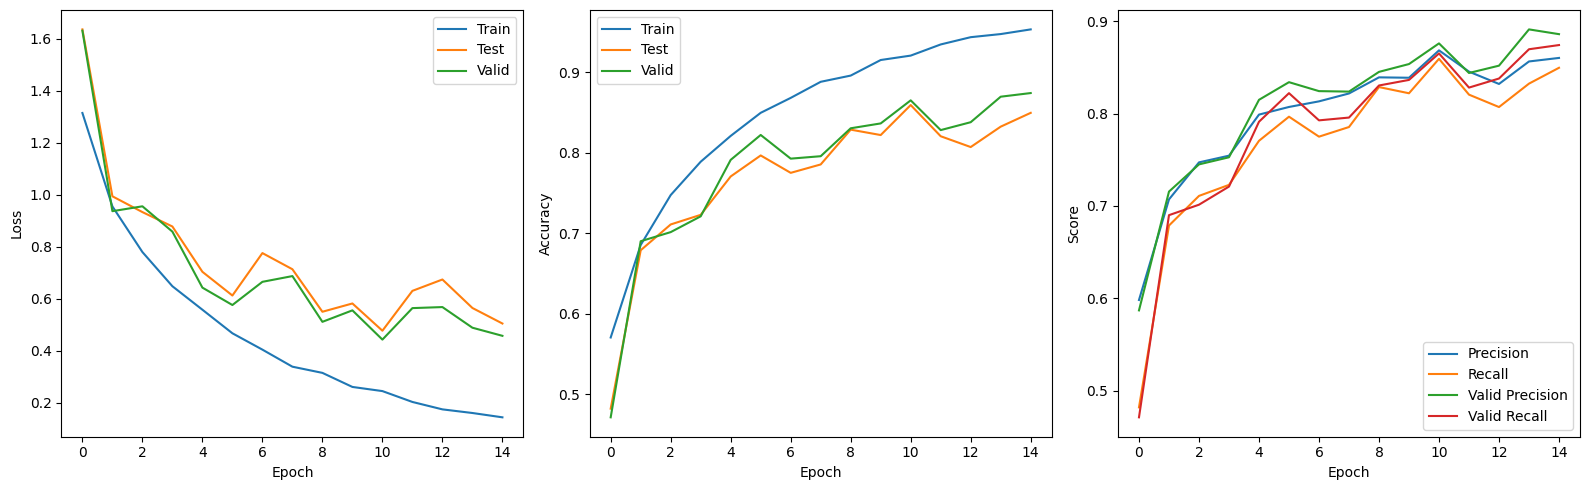

In [15]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.plot(valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.plot(valid_accuracies, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_precisions, label='Precision')
plt.plot(test_recalls, label='Recall')
plt.plot(valid_precisions, label='Valid Precision')
plt.plot(valid_recalls, label='Valid Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix

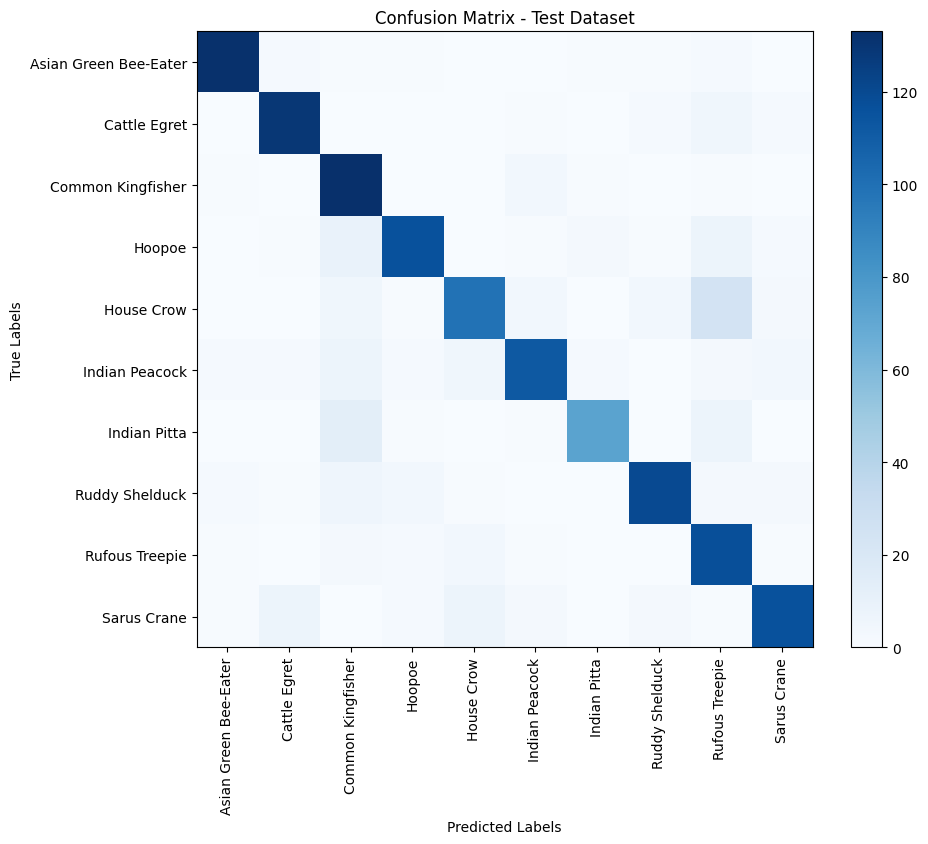

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(test_cm, cmap='Blues')
plt.title('Confusion Matrix - Test Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=range(len(bird_species)), labels=bird_species, rotation=90)
plt.yticks(ticks=range(len(bird_species)), labels=bird_species)

# thresh = confusion_matrix.max() / 2.0
# for i in range(bird_species):
#     for j in range(bird_species):
#         plt.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="white" if confusion_matrix[i, j] > thresh else "black")

plt.colorbar()
plt.show()

# TSNE visualization

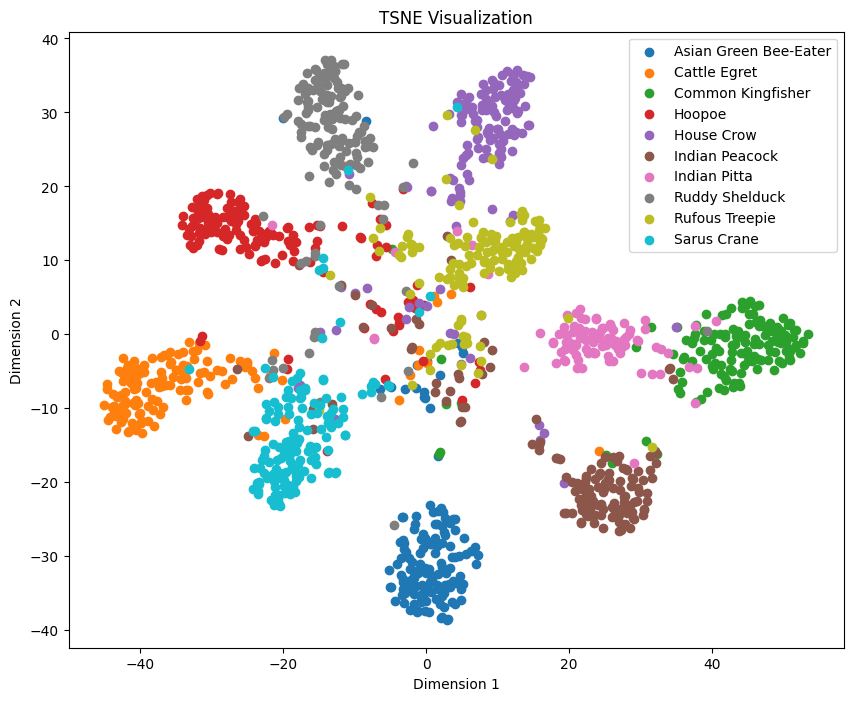

In [89]:
# Load the saved model weights
# model.load_state_dict(torch.load("resnet_model.pth"))
best_model.eval()

# Extract features using the trained model
features = []
labels = []
with torch.no_grad():
    for inputs, target in testloader:
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        features.append(outputs.cpu().numpy())
        labels.append(target.cpu().numpy())

# Concatenate features and labels
features = np.concatenate(features)
labels = np.concatenate(labels)

# Perform TSNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_embedded = tsne.fit_transform(features)

# Plot the TSNE graph
plt.figure(figsize=(10, 8))
for i, label in enumerate(bird_species):
    plt.scatter(features_embedded[labels == i, 0], features_embedded[labels == i, 1], label=label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('TSNE Visualization')
plt.legend()
plt.show()